In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pyro

## Bernoulli bandit
There is $I$ items. Each item has a probability of being clicked.  
You interact with the environment by sending an action in the step() function.

In [2]:
class SimpleBandit():
    def __init__(self, I = 10):
        self.I = I
        self.click_prob = np.random.rand(I)
    def step(self, action = None):
        p = self.click_prob[action]
        return (torch.rand((1,1)) <= p).float()

# Case 1: No knowledge of user
Let us build a high dimensional complex environment:

In [3]:
#env = ClickProbEnv(U = 50, I = 100, d = 3)
env = SimpleBandit(I = 20)
steps = 100 # number of steps in each game
evals = 100 # During evaluation, how many times should we evaluate the bandit?

#### Convergence by choosing each item many times

If you execute each action many times they will converge.

E.g. for the first ten arms:

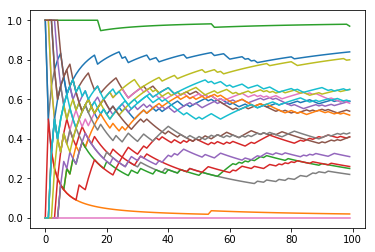

In [4]:
for i in range(env.I):
    reward = torch.cat([env.step(i) for _ in range(steps)])
    phat = reward.cumsum(0).view(-1)/torch.arange(1,steps+1).float()
    plt.plot(phat.numpy())

## Epsilon greedy
we let the bernoulli-agent do an epsilon greedy search with different epsilon parameters

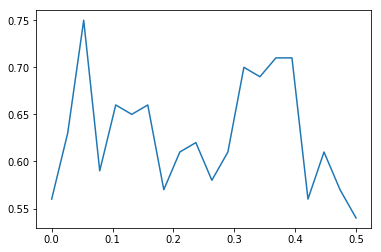

In [5]:
eps = np.linspace(0,0.5,20)
avg_reward = np.zeros(len(eps))
for t, ep in enumerate(eps):
    rewards, actions = np.ones(env.I)*0.0, np.ones(env.I)*1
    r = np.zeros(steps)
    for i in range(steps):
        # sample a user (but dont show it to the algorithm)

        # Select action:
        if np.random.rand() > ep:
            action = np.argmax(rewards/actions)
        else:
            action = np.random.randint(env.I)
        r[i] = env.step(action)


        # update algorithm
        rewards[action] += r[i]
        actions[action] += 1

    #print("epsilon: {}, Avg rewards: {}".format(ep, r.sum()/steps))
    avg_reward[t] = r.sum()/steps
phat = r.cumsum(0)/torch.arange(1,steps+1).float()
plt.plot(eps, avg_reward)


#### Performance of best epsilon

Using epsilon: 0.05263157894736842
Average reward over 100 runs: 0.6638999999999998. stddev: 0.08492225856629108


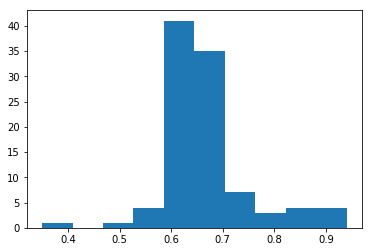

In [6]:
ep = eps[avg_reward.argmax()] # select best reward from above
print(f"Using epsilon: {ep}")
avg_reward = np.zeros(evals)
for t, _ in enumerate(avg_reward):
    rewards, actions = np.ones(env.I)*0.0, np.ones(env.I)*1
    r = np.zeros(steps)
    for i in range(steps):

        # Select action:
        if np.random.rand() > ep:
            action = np.argmax(rewards/actions)
        else:
            action = np.random.randint(env.I)
        r[i] = env.step(action)


        # update algorithm
        rewards[action] += r[i]
        actions[action] += 1

    #print("epsilon: {}, Avg rewards: {}".format(ep, r.sum()/steps))
    avg_reward[t] = r.sum()/steps
print("Average reward over {} runs: {}. stddev: {}".format(len(avg_reward), avg_reward.mean(), avg_reward.std()))
_ = plt.hist(avg_reward)

### Greedy Beta Bernoulli Bandit

Average reward over 100 runs: 0.8260000091791153. stddev: 0.1565758671458358


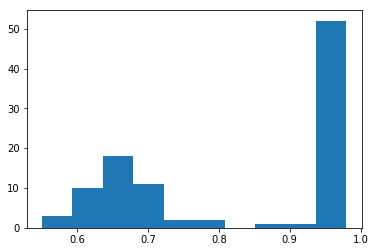

In [7]:
avg_reward = np.zeros(evals)
for t in range(evals):
    alpha, beta = torch.ones(env.I), torch.ones(env.I) #uniform prior
    r = torch.zeros(steps)
    for i in range(steps):
        
        # Select action
        action_values = alpha/(alpha+beta)
        action = action_values.argmax()
        r[i] = env.step(action)

        # update algorithm
        alpha[action] += r[i]
        beta[action] += 1-r[i]

    #print("epsilon: {}, Avg rewards: {}".format(ep, r.sum()/steps))
    avg_reward[t] = r.sum()/steps
print("Average reward over {} runs: {}. stddev: {}".format(len(avg_reward), avg_reward.mean(), avg_reward.std()))
_ = plt.hist(avg_reward)

### Thompson Sampling in Beta Bernoulli: Uniform prior
First run a visualization run

In [8]:
def plot_beta_distribution(alpha,beta,subplot=None):
    x = np.linspace(0,1)
    for a,b in zip(alpha, beta):
        y = scipy.stats.distributions.beta.pdf(x,a,b)
        plt.plot(x,y)
    plt.show()

Average reward over 100 runs: 0.753299999833107. stddev: 0.04578329193993512


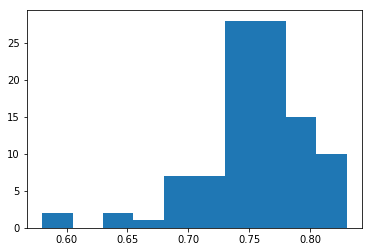

In [9]:
avg_reward = np.zeros(evals)
for t in range(evals):
    alpha, beta = torch.ones(env.I), torch.ones(env.I) 
    r = torch.zeros(steps)
    for i in range(steps):        
        # Select action
        action_values = scipy.stats.distributions.beta.rvs(alpha,beta)
        action = action_values.argmax()
        r[i] = env.step(action)

        # update algorithm
        alpha[action] += r[i]
        beta[action] += 1-r[i]

    avg_reward[t] = r.sum()/steps
print("Average reward over {} runs: {}. stddev: {}".format(len(avg_reward), avg_reward.mean(), avg_reward.std()))
_ = plt.hist(avg_reward)

### Thompson Sampling in Beta Bernoulli: varying strength of belief
We can reparameterize the beta distribution from alpha and beta to expected payoff and a strength parameter:

$$ \theta = \frac{\alpha}{\alpha + \beta} $$
$$ K = \alpha + \beta $$

We introduce an exploration parameter C so that we can explore or exploit more or less than natural for the thompson beta distribution:

$$ K_c = c*(\alpha + \beta) $$

When c < 1 we will explore more than our prior+data suggest. When c > 1 we will explore less. This can be seen as a hyperparameter in the same sense as the epsilon in epsilon-greedy algorithm. It is also tunable, and we will test 20 different values and use the best one.

In [10]:
# Reparameterize beta
beta_rvs2 = lambda theta, k : scipy.stats.distributions.beta.rvs(theta*k,k*(1-theta))

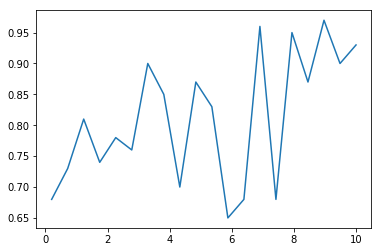

In [11]:
c_vals = np.linspace(0.2,10, 20)
avg_reward = np.zeros(len(c_vals))
for t, C in enumerate(c_vals):
    alpha, beta = torch.ones(env.I), torch.ones(env.I) 
    r = torch.zeros(steps)
    for i in range(steps):     
        # Select action
        action_values = beta_rvs2(alpha/(alpha+beta), C*(alpha + beta))
        action = action_values.argmax()
        r[i] = env.step(action)

        # update algorithm
        alpha[action] += r[i]
        beta[action] += 1-r[i]
    
    avg_reward[t] = r.mean()

plt.plot(c_vals, avg_reward)

The problem seems to benefit from exploring less than "natural".

#### Thompson sampling with optimal exploration

Average reward over 100 runs: 0.8378999984264374. stddev: 0.11128607748695742


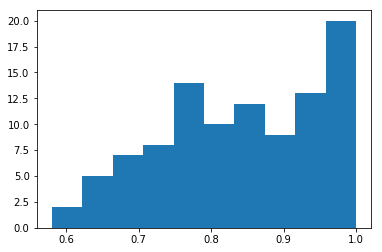

In [12]:
C = c_vals[np.argmax(avg_reward)]
avg_reward = np.zeros(evals)
for t in range(evals):
    alpha, beta = torch.ones(env.I), torch.ones(env.I) 
    r = torch.zeros(steps)
    for i in range(steps):        
        # Select action
        action_values = beta_rvs2(alpha/(alpha+beta), C*(alpha + beta))
        action = action_values.argmax()
        r[i] = env.step(action)

        # update algorithm
        alpha[action] += r[i]
        beta[action] += 1-r[i]

    avg_reward[t] = r.sum()/steps
print("Average reward over {} runs: {}. stddev: {}".format(len(avg_reward), avg_reward.mean(), avg_reward.std()))
_ = plt.hist(avg_reward)